## Passing Networks

Here we look at creating passing networks to measure centralisation. Is one player hogging the ball?

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

Once again, open the data:

In [3]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(69301)

## Preparing the data

For passing networks, we want to use accurate/successful passes made by a team until they have their first substituion. 
We need pass start and end location, as well as who made the pass to who.

In [23]:
# check the index in which the first sub is made
first_sub = df.loc[df['type_name'] == 'Substitution'].loc[df['team_name'] == "England Women's"].iloc[0]['index']

# get all the passes up until the first sub, excluding throw-ins (they count as passes)
mask_england = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.index < first_sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")

# get a dataframe with all the bits we need
df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', 'player_name', 'pass_recipient_name']]

#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

,x,y,end_x,end_y,player_name,pass_recipient_name
4,60.0,40.0,61.9,40.9,White,Kirby
8,82.6,37.6,78.4,58.5,Kirby,Bronze
11,84.7,65.3,98.9,77.9,Bronze,Parris
14,94.7,75.5,93.3,64.3,Parris,Scott
63,5.2,8.3,10.8,5.5,Moore,Mead
...,...,...,...,...,...,...
1744,52.5,42.0,40.0,34.1,Greenwood,McManus
1747,40.0,34.1,39.0,58.0,McManus,Houghton
1750,39.7,59.3,49.2,76.7,Houghton,Bronze
1753,49.8,75.2,50.5,63.1,Bronze,Kirby


## Calculating vertice size and location

To get the size of the pass network lines, we need to calculate first the average location of passes made and received for each player and then calculate the number of passes made by each player. 
At the end, we calculate the marker size to be proportional to number of passes.

In [5]:
scatter_df = pd.DataFrame()

for i, name in enumerate(df_pass['player_name'].unique()):
    pass_x_coord = df_pass.loc[df_pass['player_name'] == name]["x"].to_numpy()
    received_x_coord = df_pass.loc[df_pass['pass_recipient_name'] == name]["end_x"].to_numpy()
    pass_y_coord = df_pass.loc[df_pass['player_name'] == name]["y"].to_numpy()
    received_y_coord = df_pass.loc[df_pass['pass_recipient_name'] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name # create dataframe with each player name for a row
    
    # now we want to average our x and y for each player, so that each circle on our pitch
    # is the average of where they passed and received 
    scatter_df.at[i, "x"] = np.mean(np.concatenate([pass_x_coord, received_x_coord]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([pass_y_coord, received_y_coord]))

    # calculate number of passes
    scatter_df.at[i, "number_of_passes"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# adjust circle size to be normalized to the player who passed the most
scatter_df["marker_size"] = (scatter_df['number_of_passes'] / scatter_df['number_of_passes'].max() * 1500)

scatter_df

,player_name,x,y,number_of_passes,marker_size
0,White,82.923529,47.829412,10.0,441.176471
1,Kirby,51.942857,42.457143,26.0,1147.058824
2,Bronze,48.093750,69.543750,32.0,1411.764706
3,Parris,74.845714,67.257143,15.0,661.764706
4,Moore,58.276000,37.436000,14.0,617.647059
5,Mead,65.075758,15.590909,14.0,617.647059
6,Greenwood,52.773077,11.507692,22.0,970.588235
7,Telford,8.493750,38.568750,12.0,529.411765
8,McManus,36.892187,29.746875,34.0,1500.000000
9,Scott,54.485294,52.285294,16.0,705.882353


## Calculating edges width

To do so we need to count how many times a pair of players passed to eachother

In [33]:
# first we need to create a 'pairs' column of all the unique passing pairs
df_pass["pass_pairs"] = df_pass.apply(lambda x:"_".join(sorted([x['player_name'], x['pass_recipient_name']])), axis=1)
# then create a new df containing the counts of each pass_pair occurs
lines_df = df_pass.groupby(["pass_pairs"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True) # replace column name

# now we set a threshold for what will create a pass line. we will use 2 here
lines_df = lines_df[lines_df['pass_count']>2]

lines_df

,pass_pairs,pass_count
0,Bronze_Houghton,16
1,Bronze_Kirby,9
2,Bronze_McManus,4
4,Bronze_Moore,4
5,Bronze_Parris,16
6,Bronze_Scott,11
7,Bronze_White,3
9,Greenwood_Kirby,6
10,Greenwood_McManus,20
11,Greenwood_Mead,17


## Plotting nodes

Now lets plot the players first in their average locations and size determined by number of passes made

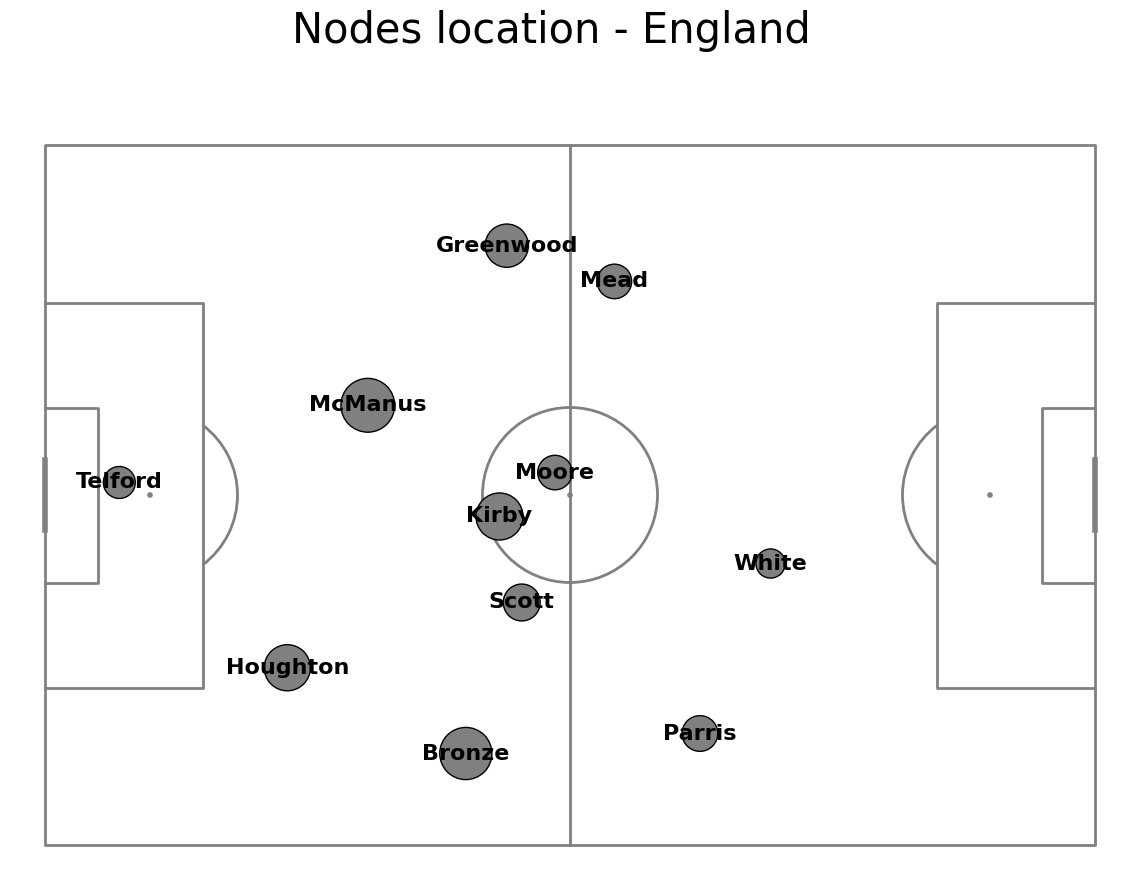

In [32]:
pitch = Pitch(pitch_type='statsbomb', line_color='grey')
fig, ax = pitch.draw(figsize=(15, 10), constrained_layout=True, tight_layout=False)

# plot the average positions
pitch.scatter(scatter_df.x, scatter_df.y, alpha = 1, s = scatter_df.marker_size, color = "grey", ax=ax, edgecolor="black")

# plot the player names too
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax, zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

## Plotting edges

Now for each combination of players, we query our dataframe to get the start and end positions of where our lines should be. Then we adjust the linewidth so that the more passes have a wider line.

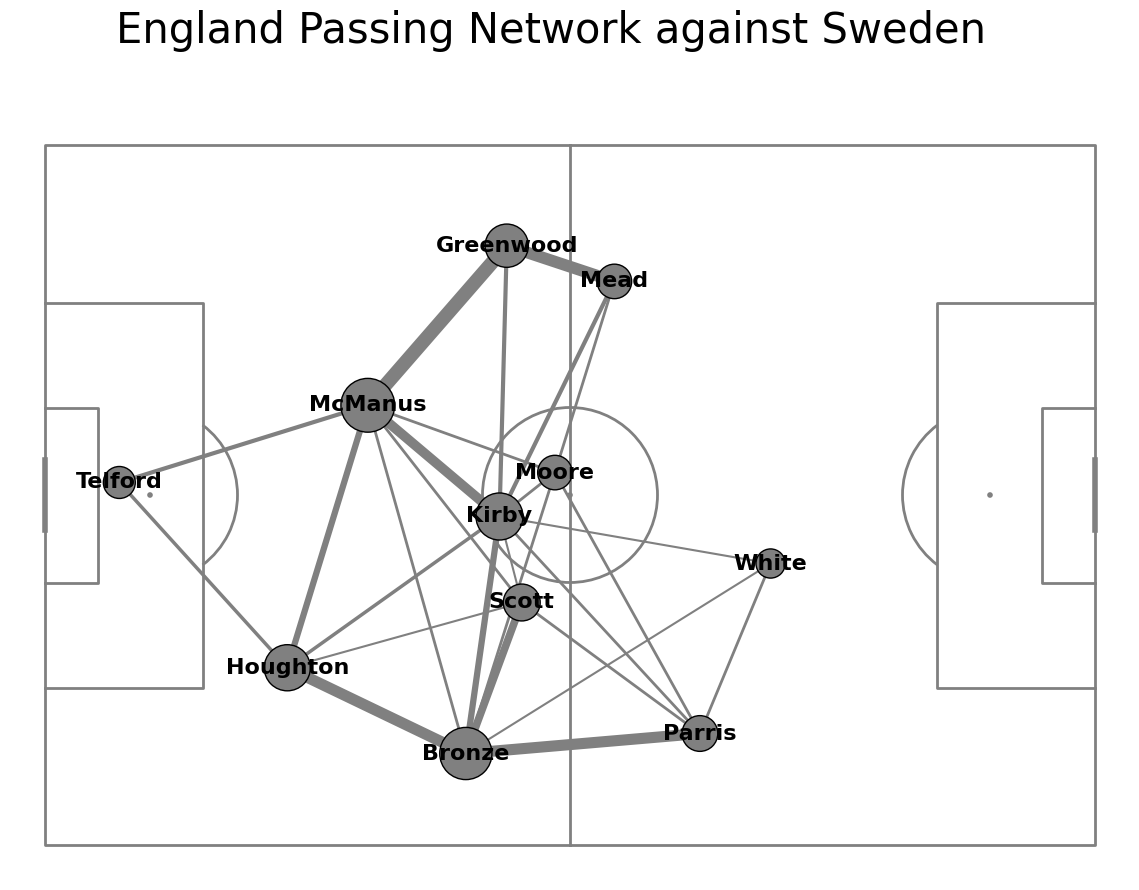

In [44]:
# plot once again the pitch and nodes
pitch = Pitch(pitch_type='statsbomb', line_color='grey')
fig, ax = pitch.draw(figsize=(15, 10), constrained_layout=True, tight_layout=False)

# plot the average positions
pitch.scatter(scatter_df.x, scatter_df.y, alpha = 1, s = scatter_df.marker_size, color = "grey", ax=ax, edgecolor="black", zorder=4)

# plot the player names too
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax, zorder = 4)


for i, row in lines_df.iterrows():
    # get the player names from the pass pairs
    player1 = row["pass_pairs"].split("_")[0]
    player2 = row['pass_pairs'].split("_")[1]
    # get each players average positions for the line start and end
    player1_x = scatter_df.loc[scatter_df['player_name'] == player1]['x'].iloc[0]
    player2_x = scatter_df.loc[scatter_df['player_name'] == player2]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df['player_name'] == player1]['y'].iloc[0]
    player2_y = scatter_df.loc[scatter_df['player_name'] == player2]['y'].iloc[0]
    #adjust the line width so that the more passes, the wider the line
    line_width = (row['pass_count'] / lines_df['pass_count'].max() * 10)
    #plot lines on the pitch. zorder is the z-height of the line, so you want this 'below' the names and nodes
    pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=1, lw=line_width, zorder=2, color="grey", ax = ax)

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()